<a href="https://colab.research.google.com/github/a7m-1st/keras-vggface-updated/blob/master/FER_Pre_trained_VGGFace_Fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original: [https://www.kaggle.com/code/vumerenko/fer-pre-trained-vggface-fine-tune/notebook](https://www.kaggle.com/code/vumerenko/fer-pre-trained-vggface-fine-tune/notebook)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deadskull7/fer2013")

print("Path to dataset files:", path)

100%|██████████| 96.6M/96.6M [00:00<00:00, 180MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import os
import gc

# TODO:
# 1. Use data augmentation
# 2. Fine-tune best model on data augmentation
# 3. Evaluate on test set

df = pd.read_csv(path + "/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
idx_to_emotion_fer = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

In [ ]:
X_train, y_train = np.rollaxis(df[df.Usage == "Training"][["pixels", "emotion"]].values, -1)
X_train = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_train]).reshape((-1, 48, 48))
y_train = y_train.astype('int8')

X_test_public, y_test_public = np.rollaxis(df[df.Usage == "PublicTest"][["pixels", "emotion"]].values, -1)
X_test_public = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_test_public]).reshape((-1, 48, 48))
y_test_public = y_test_public.astype('int8')

X_test_private, y_test_private = np.rollaxis(df[df.Usage == "PrivateTest"][["pixels", "emotion"]].values, -1)
X_test_private = np.array([np.fromstring(x, dtype="uint8", sep=" ") for x in X_test_private]).reshape((-1, 48, 48))
y_test_private = y_test_private.astype('int8')

In [ ]:
print(f"X_train shape: {X_train.shape}; y_train shape: {y_train.shape}")
print(f"X_test_public shape: {X_test_public.shape}; y_test_public shape: {y_test_public.shape}")
print(f"X_test_private shape: {X_test_private.shape}; y_test_private shape: {y_test_private.shape}")

X_train shape: (28709, 48, 48); y_train shape: (28709,)
X_test_public shape: (3589, 48, 48); y_test_public shape: (3589,)
X_test_private shape: (3589, 48, 48); y_test_private shape: (3589,)


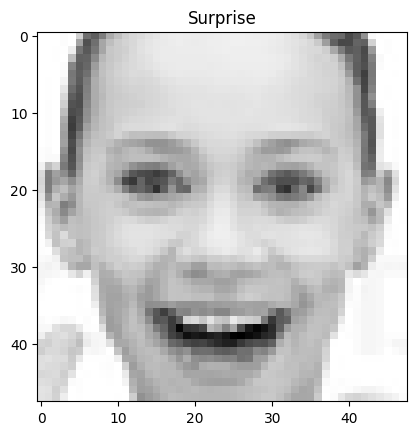

In [ ]:
plt.imshow(X_test_private[10], interpolation='none', cmap='gray')
plt.title(idx_to_emotion_fer[y_test_private[10]])
plt.show()

In [ ]:
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def one_hot(y):
    return to_categorical(y, 7)

In [ ]:
!pip uninstall keras-vggface -y
!pip install keras_applications
!pip install --no-cache-dir git+https://github.com/a7m-1st/keras-vggface-updated.git
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

Found existing installation: keras_vggface 0.6
Uninstalling keras_vggface-0.6:
  Successfully uninstalled keras_vggface-0.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00
  Cloning https://github.com/a7m-1st/keras-vggface-updated.git to /tmp/pip-req-build-yv1pfls1
  Running command git clone --filter=blob:none --quiet https://github.com/a7m-1st/keras-vggface-updated.git /tmp/pip-req-build-yv1pfls1
  Resolved https://github.com/a7m-1st/keras-vggface-updated.git to commit 11926c62e18455dfc0db65664c96ab28554fca2a
  Preparing metadata (setup.py) ... done
  Created wheel for keras_vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8291 sha256=dbf505dfc20cd23f0a6972d483767c8c1e1501f95c8ec08a68cdbc9af5766c5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-901cud2i/wheels/5d/ab/0c/aab0e85d49dc9c0424b7ad4c8f02804c08db78f96b94e26866
Successfully built keras_vggface


In [ ]:
VGGFace(include_top = False, input_shape = (48,48,3),pooling = 'avg').summary()

58909280/58909280 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vggface_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_3 (Conv2D)                     │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_2 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_3 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_1 (Conv2D)                     │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_2 (Conv2D)                     │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_3 (Conv2D)                     │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling2D)                 │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, y_train = X_train.reshape((-1, 48, 48, 1)), one_hot(y_train)
X_val, y_val = X_test_public.reshape((-1, 48, 48, 1)), one_hot(y_test_public)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)


In [ ]:
# X_small_train, _, y_small_train, _ = train_test_split(X_train, y_train, train_size=0.9)

def create_normalize(mean, std):
    def normalize(X):
        return (X - mean) / std
    return normalize

# X_mean = X_train.mean(axis=0)
# X_std = X_train.std(axis=0)

# X_small_val, _, y_small_val, _ = train_test_split(X_val, y_val, train_size=0.9)

# normalize = create_normalize(X_mean, X_std)

# X_train_norm = normalize(X_train)
# X_val_norm = normalize(X_val)

# print(X_train_norm.shape, X_val_norm.shape)

In [ ]:
X_test, y_test = X_test_private.reshape((-1, 48, 48, 1)), one_hot(y_test_private)

X_train_all = np.concatenate((X_train, X_val), axis=0)
y_train_all = np.concatenate((y_train, y_val), axis=0)

X_train_mix, X_val_mix, y_train_mix, y_val_mix = \
    train_test_split(X_train_all, y_train_all, test_size=0.1)

print(X_train_mix.shape, y_train_mix.shape, X_val_mix.shape, y_val_mix.shape)

X_mix_mean = X_train_mix.mean(axis=0)
X_mix_std = X_train_mix.std(axis=0)

normalize_mix = create_normalize(X_mix_mean, X_mix_std)
X_train_mix_norm = normalize_mix(X_train_mix)
X_val_mix_norm = normalize_mix(X_val_mix)

X_test_norm = normalize_mix(X_test)

print(X_train_mix_norm.shape, y_train_mix.shape, X_val_mix_norm.shape, y_val_mix.shape)

# Update the dimentions to rgb (3)
X_train_mix_norm = np.repeat(X_train_mix_norm, 3, axis=-1)
X_val_mix_norm   = np.repeat(X_val_mix_norm, 3, axis=-1)
X_test_norm      = np.repeat(X_test_norm, 3, axis=-1)

(29068, 48, 48, 1) (29068, 7) (3230, 48, 48, 1) (3230, 7)
(29068, 48, 48, 1) (29068, 7) (3230, 48, 48, 1) (3230, 7)


In [ ]:
from keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.layers import Flatten, Dense, Input, Concatenate, Dropout, BatchNormalization, ReLU
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

In [ ]:
def compose_model(feature_extractor, reg=0.0):
    inputs = Input(shape=(48, 48, 3))  # symbolic input tensor
    conv_output = feature_extractor(inputs)  # symbolic flow

    dense_1   = Dense(1024, kernel_regularizer=l2(reg))(conv_output)
    bn_1      = BatchNormalization()(dense_1)
    relu_1    = ReLU()(bn_1)
    dropout_1 = Dropout(0.5)(relu_1)

    dense_2   = Dense(1024, activation='relu', kernel_regularizer=l2(reg))(dropout_1)
    outputs   = Dense(7, activation='softmax')(dense_2)

    return Model(inputs=inputs, outputs=outputs)

def train(params):
    print('training with {} params'.format(params))

    vgg_features = VGGFace(weights='vggface', include_top=False, input_shape=(48,48,3), pooling='max')
    # for x in vggfeatures.layers[:-5]: # [:-5] [:-9]
    #     x.trainable = False
    model = compose_model(vgg_features, reg=params['reg'])

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=params.get('lr')), metrics=['categorical_accuracy'])

    batch_size = params['batch_size']

    y_train_flattened = y_train.ravel()  # or y_train.flatten()
    print(np.unique(y_train))
    # Compute class weights
    cat_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(y_train_flattened),
                                                    y=y_train_flattened)

    # Convert the class weights to a dictionary
    class_weight_dict = dict(zip(np.unique(y_train_flattened), cat_weights))

    print(class_weight_dict)

    # Pass class_weight_dict to model.fit
    history = model.fit(
        X_train_mix_norm,
        y_train_mix,
        batch_size=params['batch_size'],
        epochs=10,
        validation_data=(X_val_mix_norm, y_val_mix),
        class_weight=class_weight_dict  # Use the dictionary here
    )

    return model, history

params = {
    'reg': 0.5,
    'lr': 5e-05,
    'batch_size': 64
}

model, history = train(params)

# params = {
#     'reg': [0.2, 0.4, 0.6, 0.8],
#     'lr': [1e-3, 3e-4, 1e-4, 1e-5],
#     'batch_size': [64, 128, 256]
# }

# scores = []

# for reg in params['reg']:
#     for lr in params['lr']:
#         for batch_size in params['batch_size']:
#             config = {
#                 'reg': reg,
#                 'lr': lr,
#                 'batch_size': batch_size
#             }

#             score = train(config)
#             scores.append([score, config])

training with {'reg': 0.5, 'lr': 5e-05, 'batch_size': 64} params
[0. 1.]
{0.0: 0.5833333333333334, 1.0: 3.5}
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - categorical_accuracy: 0.2974 - loss: 652.3124 - val_categorical_accuracy: 0.4189 - val_loss: 243.8869
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 80ms/step - categorical_accuracy: 0.4790 - loss: 180.3638 - val_categorical_accuracy: 0.5025 - val_loss: 57.9685
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - categorical_accuracy: 0.5485 - loss: 41.0496 - val_categorical_accuracy: 0.5282 - val_loss: 11.3022
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - categorical_accuracy: 0.6197 - loss: 7.6619 - val_categorical_accuracy: 0.5266 - val_loss: 2.5986
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - categorical_accuracy: 0.6971 - loss: 1.6488 - val_categorical_accuracy: 0.5378 - val_loss: 1.5044
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - categorical_accuracy: 0.7773 - loss: 0.7626 - val_categ

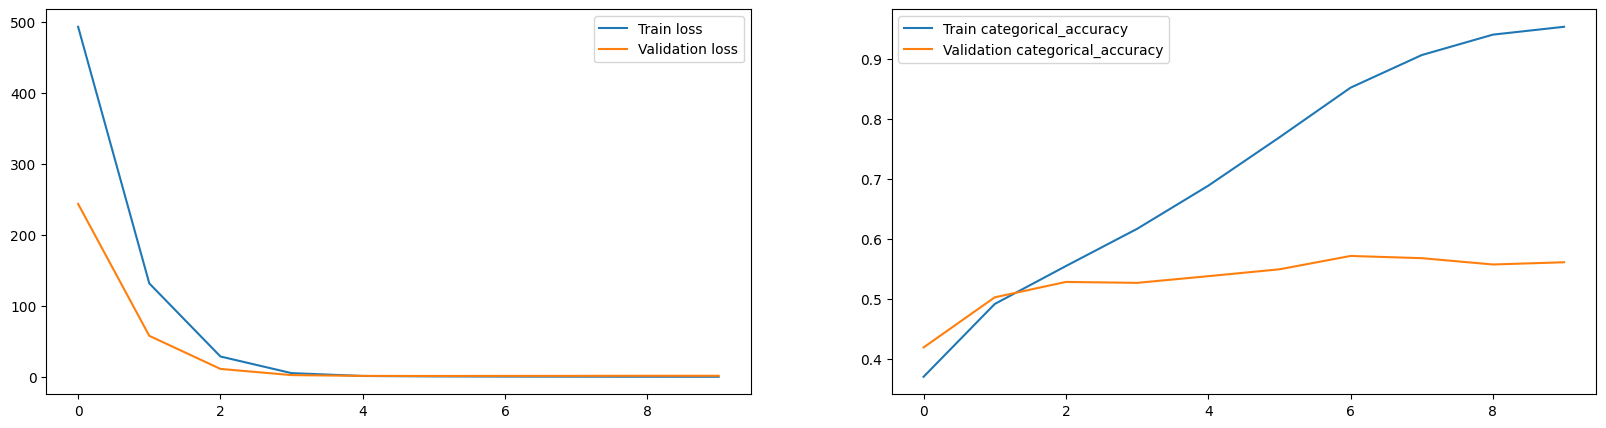

In [ ]:
def plot_history(history, metrics):
    fig, ax = plt.subplots(1, 1+len(metrics), figsize=(20, 5))
    ax[0].plot(history.history['loss'], label='Train loss')
    ax[0].plot(history.history['val_loss'], label='Validation loss')
    ax[0].legend()

    for i, metric in enumerate(metrics):
        ax[i+1].plot(history.history[metric], label='Train %s' % metric)
        ax[i+1].plot(history.history['val_%s' % metric], label='Validation %s' % metric)
        ax[i+1].legend()

    plt.show()
plot_history(history, metrics=['categorical_accuracy'])

## Prediction

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
              precision    recall  f1-score   support

           0       0.38      0.65      0.48       491
           1       0.40      0.78      0.53        55
           2       0.52      0.41      0.46       528
           3       0.76      0.81      0.79       879
           4       0.52      0.29      0.37       594
           5       0.85      0.69      0.76       416
           6       0.55      0.56      0.56       626

    accuracy                           0.58      3589
   macro avg       0.57      0.60      0.56      3589
weighted avg       0.60      0.58      0.58      3589



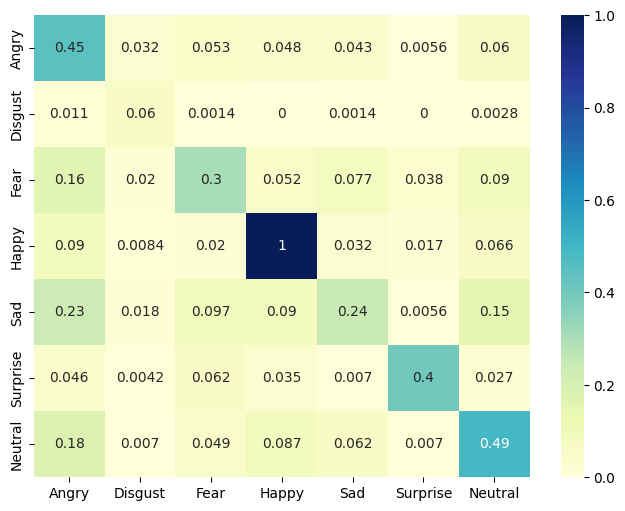

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# X_test, y_test = X_fer_test_private.reshape((-1, 48, 48, 1)), one_hot(y_fer_test_private)


def evaluate(model):
    labels = idx_to_emotion_fer.values()

    y_pred = model.predict(X_test_norm)

    y_true_cat = np.argmax(y_test, axis=1)
    y_pred_cat = np.argmax(y_pred, axis=1)

    report = classification_report(y_true_cat, y_pred_cat)
    print(report)

    conf = confusion_matrix(y_true_cat, y_pred_cat)
    conf = conf / np.max(conf)

    _, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(conf, annot=True, cmap='YlGnBu',
                     xticklabels=labels,
                     yticklabels=labels)
    plt.show()

    return report


report = evaluate(model)

## Download Model

In [ ]:
import json

model_json = model.to_json()
with open('model.json', 'w') as f:
    f.write(model_json)

with open('params.json', 'w') as f:
    f.write(json.dumps({
        'reg': 0.5,
        'lr': 5e-5,
        'batch_size': 64
    }))

with open('report.txt', 'w') as f:
    f.write(report)

model.save_weights('model.h5')